## Convolutional Neural Network 활용
-----
- CNN을 구성하는 주요 연산을 이해하고, 신경망을 설계한다.
- AlexNet을 사용하여 이미지를 학습하고 10개의 카테고리를 갖는 이미지를 분류하는 이미지 분류기를 생성한다. (데이터셋: [CIFAR](https://pytorch.org/vision/0.9/datasets.html#cifar))
- 이미지 증강을 수행하여 모델의 성능을 높이는 방법을 이해한다.
- Confusion Matrix를 생성하여 분류 정확도를 확인한다.
- **reference**
    - https://tutorials.pytorch.kr/beginner/basics/buildmodel_tutorial.html
    - https://tutorials.pytorch.kr/beginner/basics/data_tutorial.html
    - https://medium.com/@djin31/how-to-plot-wholesome-confusion-matrix-40134fd402a8

In [ ]:
# 1번
# 필요한 모듈을 모두 이곳에 나열하세요
# 2점
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

In [ ]:
# 2번
# CIFAR 데이터(train, test)를 불러오세요
# 2점
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True
)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:04<00:00, 38778419.30it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
# 3번
# 불러온 이미지의 증강을 합니다.
# RandomCrop, RandomHorizontalFlip, Normalize
# Compose 함수를 이용합니다.
# train에는 RandomCrop, RandomHorizontalFlip, Normalize를 적용한다.
# test에는 Normalize를 적용한다.
# 2점

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(32), # 이미지를 무작위로 crop하여 32*32로 만듦
    transforms.RandomHorizontalFlip(),  # 랜덤하게 좌우반전
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 각 채널을 평균과 표준편차 0.5로 정규화
    ])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# train과 test 데이터셋의 transform에 적용
training_data.transform = train_transform
test_data.transform = test_transform

In [ ]:
training_data.transform

Compose(
    ToTensor()
    RandomCrop(size=(32, 32), padding=None)
    RandomHorizontalFlip(p=0.5)
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

In [ ]:
test_data.transform

Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

In [ ]:
# 4번
# Device 설정은 GPU로 합니다
# 2점
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# 학습 다 돌리고 GPU 다써서 cpu로 출력되네요..😭

cuda


In [ ]:
# 5번
# train, test의 shape를 확인합니다.
# 2점
for i in [training_data, test_data]:
  if i == training_data:
    train_sample, _ = i[0]
    train_shape = train_sample.shape
    print(train_shape)
  else:
    test_sample, _ = i[0]
    test_shape = test_sample.shape
    print(test_shape)

torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


In [ ]:
# 6번
# train, test DataLoader를 만듭니다.
# 배치사이즈: 128
# 2점
dataloaders = {
    'train':DataLoader(
        training_data,
        batch_size=128,
        shuffle=True
    ),
    'test': DataLoader(
        test_data,
        batch_size=128,
        shuffle=False
    )
}

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

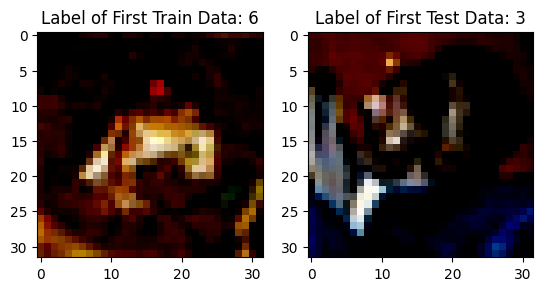

In [ ]:
# 7번
# train, test의 첫번째 인덱스 데이터를 이미지로 확인합니다.
# 2점
plt.subplot(1,2,1)
img, label = training_data[0]
plt.imshow(img.permute(1,2,0))  # (h, w, channel)로 변환
plt.title(f'Label of First Train Data: {label}')

plt.subplot(1,2,2)
test_img, test_label = test_data[0]
plt.imshow(test_img.permute(1,2,0))
plt.title(f'Label of First Test Data: {test_label}')
plt.show()

In [ ]:
# 8번
# 아래 코드를 실행해서 labels_map 객체를 딕셔너리로 생성합니다.
# 2점

labels_map = {
    0: "plane",
    1: "car",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

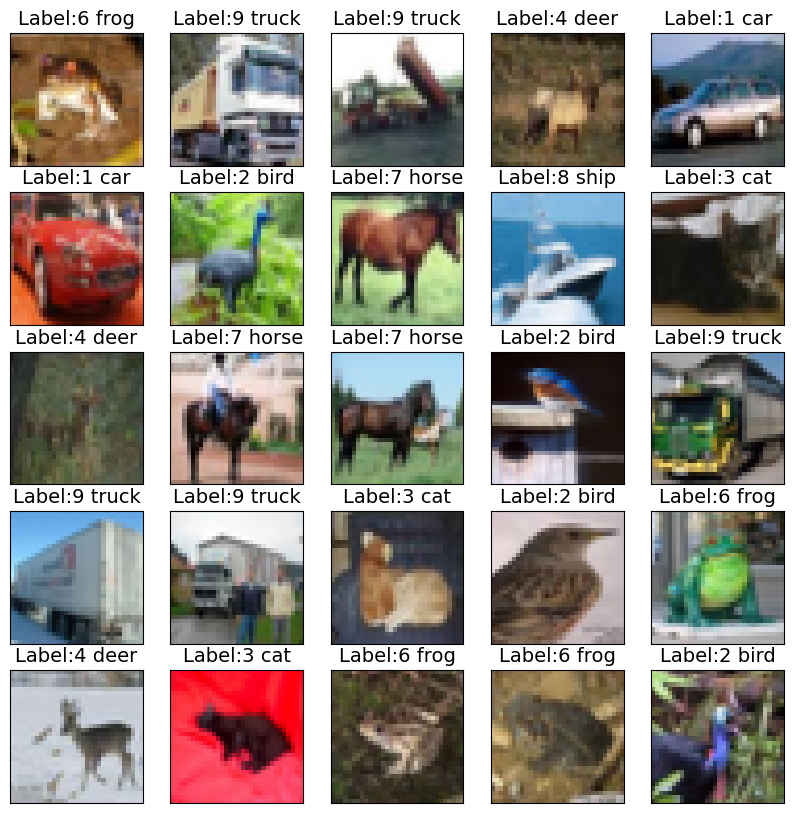

In [ ]:
# 9번
# 5행 5열로 train 데이터를 이미지로 출력합니다.
# labels_map를 이용하여 이미지의 label도 함께 출력합니다.
# 2점
# 이미지를 출력하는 함수
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
# 5행 5열의 학습 데이터 이미지와 레이블 출력
fig = plt.figure(figsize=(10, 10))
rows = 5
cols = 5
for i in range(rows * cols):
    image, label = training_data[i]
    title = 'Label:' + str(label) +' '+ labels_map[label]
    ax = fig.add_subplot(rows, cols, i + 1, xticks=[], yticks=[])
    imshow(image)
    ax.set_title(title, fontsize=14)
# 이미지 표시
plt.tight_layout

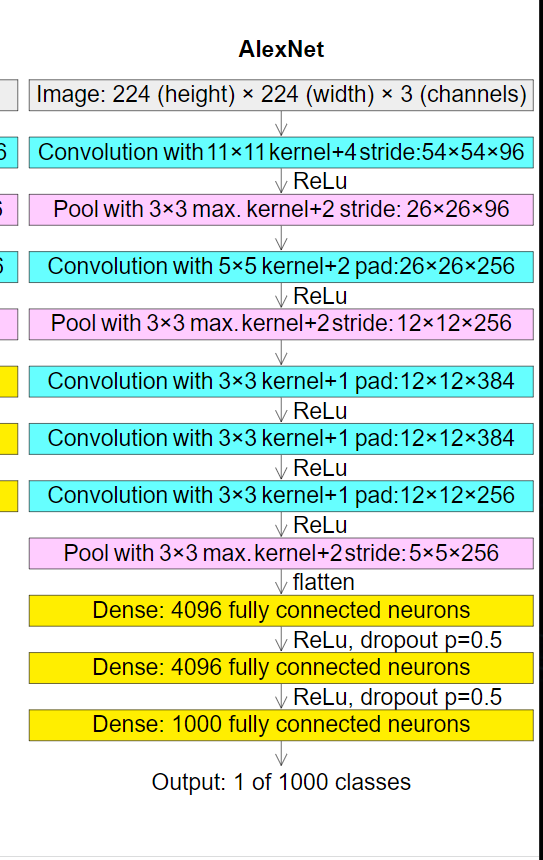

In [ ]:
# # 10번
# # AlexNet(https://en.wikipedia.org/wiki/File:Comparison_image_neural_networks.svg)
# # 위 모델을 참조하여 class를 만듭니다.
# # 2점
# class AlexNet(nn.Module):
#     def __init__(self):
#         super(AlexNet, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 96, kernel_size=11, stride=4),  # 입력채널 3(컬러 이미지), 출력 96
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),

#             nn.Conv2d(96, 256, kernel_size=5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),

#             nn.Conv2d(256, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),

#             nn.Conv2d(384, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),

#             nn.Conv2d(384, 256, kernel_size=3,  padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#         )

#         self.classifier = nn.Sequential(
#             nn.Linear(256 * 3 * 3, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.5),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.5),
#             nn.Linear(4096, 10),
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = torch.flatten(x, 1)
#         x = self.classifier(x)
#         return x

In [ ]:
# 10번
# AlexNet(https://en.wikipedia.org/wiki/File:Comparison_image_neural_networks.svg)
# 위 모델을 참조하여 class를 만듭니다.
# 2점
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=3, stride=1, padding=1),  # 입력채널 3(컬러 이미지), 출력 96
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(96, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
# 11번
# 인공신경망 객체를 GPU에 저장합니다.
# 3점
model = AlexNet().to(device)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_feature

In [ ]:
# 12번
# Loss 함수를 정의합니다.
# 학습률을 0.001로 설정합니다.
# 옵티마이저는 Adam을 사용합니다.
# 3점

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 13번
# 학습 함수를 train_loop로 작성합니다.
# 매개변수(데이터로더, 모델, loss 함수, 옵티마이저)
# 데이터로더의 인덱스가 배치사이즈 마다loss를 출력합니다.
# 3점
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % dataloader.batch_size == 0:
      loss_value=loss.item()
      processed = batch * len(X)
      print(f"Loss: {loss_value:>7f} [{processed:>5d}/{size:>5d}]")


In [ ]:
# 14번
# 테스트 함수를 test_loop로 작성합니다.
# 매개변수(데이터로더, 모델, loss 함수)
# 데이터로더의 크기만큼 반복하며 loss를 출력하고 전체 accuracy와 평균 loss를 구합니다.
# 3점
def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  model.eval()

  with torch.no_grad():
    for X, y in dataloader:
      X,y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred,y).item()
      correct += (pred.argmax(1)==y).type(torch.float).sum().item()

    test_loss /= num_batches
    accuracy = (correct / size) * 100
    print(f'Test Error: \n Accuracy:{accuracy:>0.1f}%, Avg loss: {test_loss:8f} \n')

In [ ]:
# 15번
# 100번의 epochs를 돌며 학습을 반복합니다.
# 3점
epochs = 50

for i in range(epochs):
    print(f'Epoch {i+1}\---------------------')
    train_loop(dataloaders['train'], model, loss_fn, optimizer)
    test_loop(dataloaders['test'], model, loss_fn)
print('끝!')

Epoch 1\---------------------
Loss: 2.302721 [    0/50000]
Loss: 1.714959 [16384/50000]
Loss: 1.494809 [32768/50000]
Loss: 1.535372 [49152/50000]
Test Error: 
 Accuracy:46.0%, Avg loss: 1.428480 

Epoch 2\---------------------
Loss: 1.430068 [    0/50000]
Loss: 1.374026 [16384/50000]
Loss: 1.163399 [32768/50000]
Loss: 0.992559 [49152/50000]
Test Error: 
 Accuracy:58.9%, Avg loss: 1.127257 

Epoch 3\---------------------
Loss: 1.214694 [    0/50000]
Loss: 1.063804 [16384/50000]
Loss: 1.118431 [32768/50000]
Loss: 1.042846 [49152/50000]
Test Error: 
 Accuracy:66.1%, Avg loss: 0.969958 

Epoch 4\---------------------
Loss: 0.928626 [    0/50000]
Loss: 0.879858 [16384/50000]
Loss: 1.126171 [32768/50000]
Loss: 0.932061 [49152/50000]
Test Error: 
 Accuracy:68.8%, Avg loss: 0.890591 

Epoch 5\---------------------
Loss: 0.826872 [    0/50000]
Loss: 0.796115 [16384/50000]
Loss: 0.789406 [32768/50000]
Loss: 0.861647 [49152/50000]
Test Error: 
 Accuracy:72.5%, Avg loss: 0.796771 

Epoch 6\-------

In [ ]:
# 16번
# 사이킷런의 confusion_matrix를 활용해 학습된 결과에 대해 분석합니다.
# 분석한 결과를 간단히 서술합니다.
# 3점
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
  for images, labels in dataloaders['test']:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())

# 혼동 행렬 계산
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[815  10  40  16   7   2   4   6  74  26]
 [ 15 875   2   7   2   0   5   1  27  66]
 [ 55   3 732  66  47  29  19  25  15   9]
 [ 21   5  65 647  42 100  37  42  30  11]
 [ 19   3  67  96 691  33  28  46  12   5]
 [  9   0  70 174  20 651  15  41  10  10]
 [  9   4  56  76  13  12 800   7  15   8]
 [ 15   3  33  44  35  35   4 802   9  20]
 [ 44  17   4  12   1   2   2   3 897  18]
 [ 31  51   6  11   1   4   1   4  33 858]]


> 각 셀의 값은 해당 클래스를 실제로 얼마나 정확하게 예측했는지를 나타냄
* 예) 2열 3행이 2 ->  실제 레이블값이 3인 이미지를 2로 예측함

> 대각선의 값이 클수록 잘 예측했다고 평가할 수 있음


In [ ]:
# 17번
# 학습된 파라미터를 저장합니다.
# 파일명은 model_weights.pth로 합니다.
# 3점
torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
# 18번
# 새로운 인공신경망을 GPU에 만들고 위 학습된 파일(model_weights.pth)을 불러옵니다.
# 3점
model2 = AlexNet().to(device)
model2.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>

In [ ]:
# 19번
# 위 모델에 test 데이터로더를 입력하고 결과를 확인합니다.
# 3점
model2.eval()
test_loop(dataloaders['test'], model2, loss_fn)

Test Error: 
 Accuracy:78.0%, Avg loss: 0.831625 



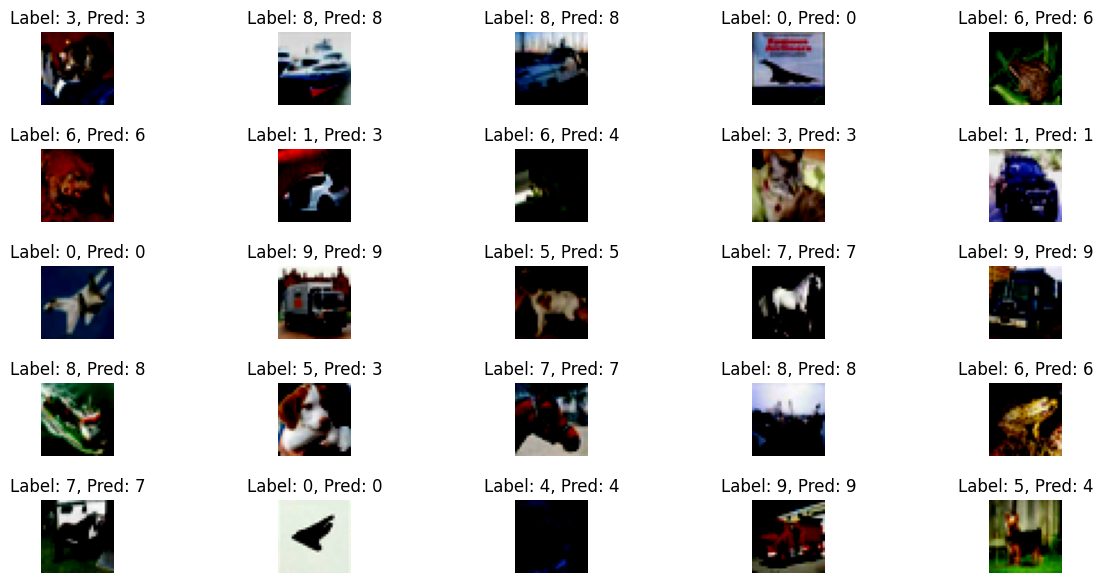

In [ ]:
# 20번
# 5행 5열로 test 데이터를 이미지로 출력합니다.
# 학습된 모델이 분류기가 잘 작동하는지 label과 예측된 결과를 동시에 출력합니다.
# 3점

import numpy as np
def plot_images_predictions(images, labels, predictions):
  images = images.cpu().numpy()
  labels = labels.cpu().numpy()
  predictions = predictions.cpu().numpy()

  fig, axs = plt.subplots(5, 5, figsize=(12, 6))
  fig.tight_layout()

  for i in range(5):
    for j in range(5):
      idx = i * 5 + j  # 이미지 인덱스 계산
      img = images[idx].squeeze()  # 이미지 텐서에서 차원 축소
      true_label = labels[idx]  # 정답 레이블
      pred_label = predictions[idx]  # 예측 레이블

      img = torch.from_numpy(img).permute(1, 2, 0)  # 축 순서 변경
      axs[i, j].imshow(img)  # 이미지 출력
      axs[i, j].set_title(f"Label: {true_label}, Pred: {pred_label}")  # 제목 설정
      axs[i, j].axis('off')  # 축 제거

  plt.show()


# 테스트 데이터의 배치 가져오기
test_batch = next(iter(dataloaders['test']))

# 테스트 데이터의 이미지와 레이블 추출
test_images, test_labels = test_batch

# 모델의 예측 수행
model2.eval()

# 평가일때 기울기 업데이트x
with torch.no_grad():
    test_predictions = model2(test_images.to(device))

# 예측 결과 시각화
plot_images_predictions(test_images, test_labels, test_predictions.argmax(dim=1))
